In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import glob
from music21 import converter, instrument, note, chord, stream
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
import librosa
from matplotlib import pyplot as plt

In [ ]:
def plot_pitch_time(audio_file):
    y, sr = librosa.load(audio_file)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = pitches.mean(axis=0)
    time = np.arange(len(pitch_mean)) * librosa.frames_to_time(1, sr=sr)
    plt.figure(figsize=(12, 6))
    plt.plot(time, pitch_mean, label='Pitch (Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch (Hz)')
    plt.title('Pitch vs. Time')
    plt.legend()
    plt.show()

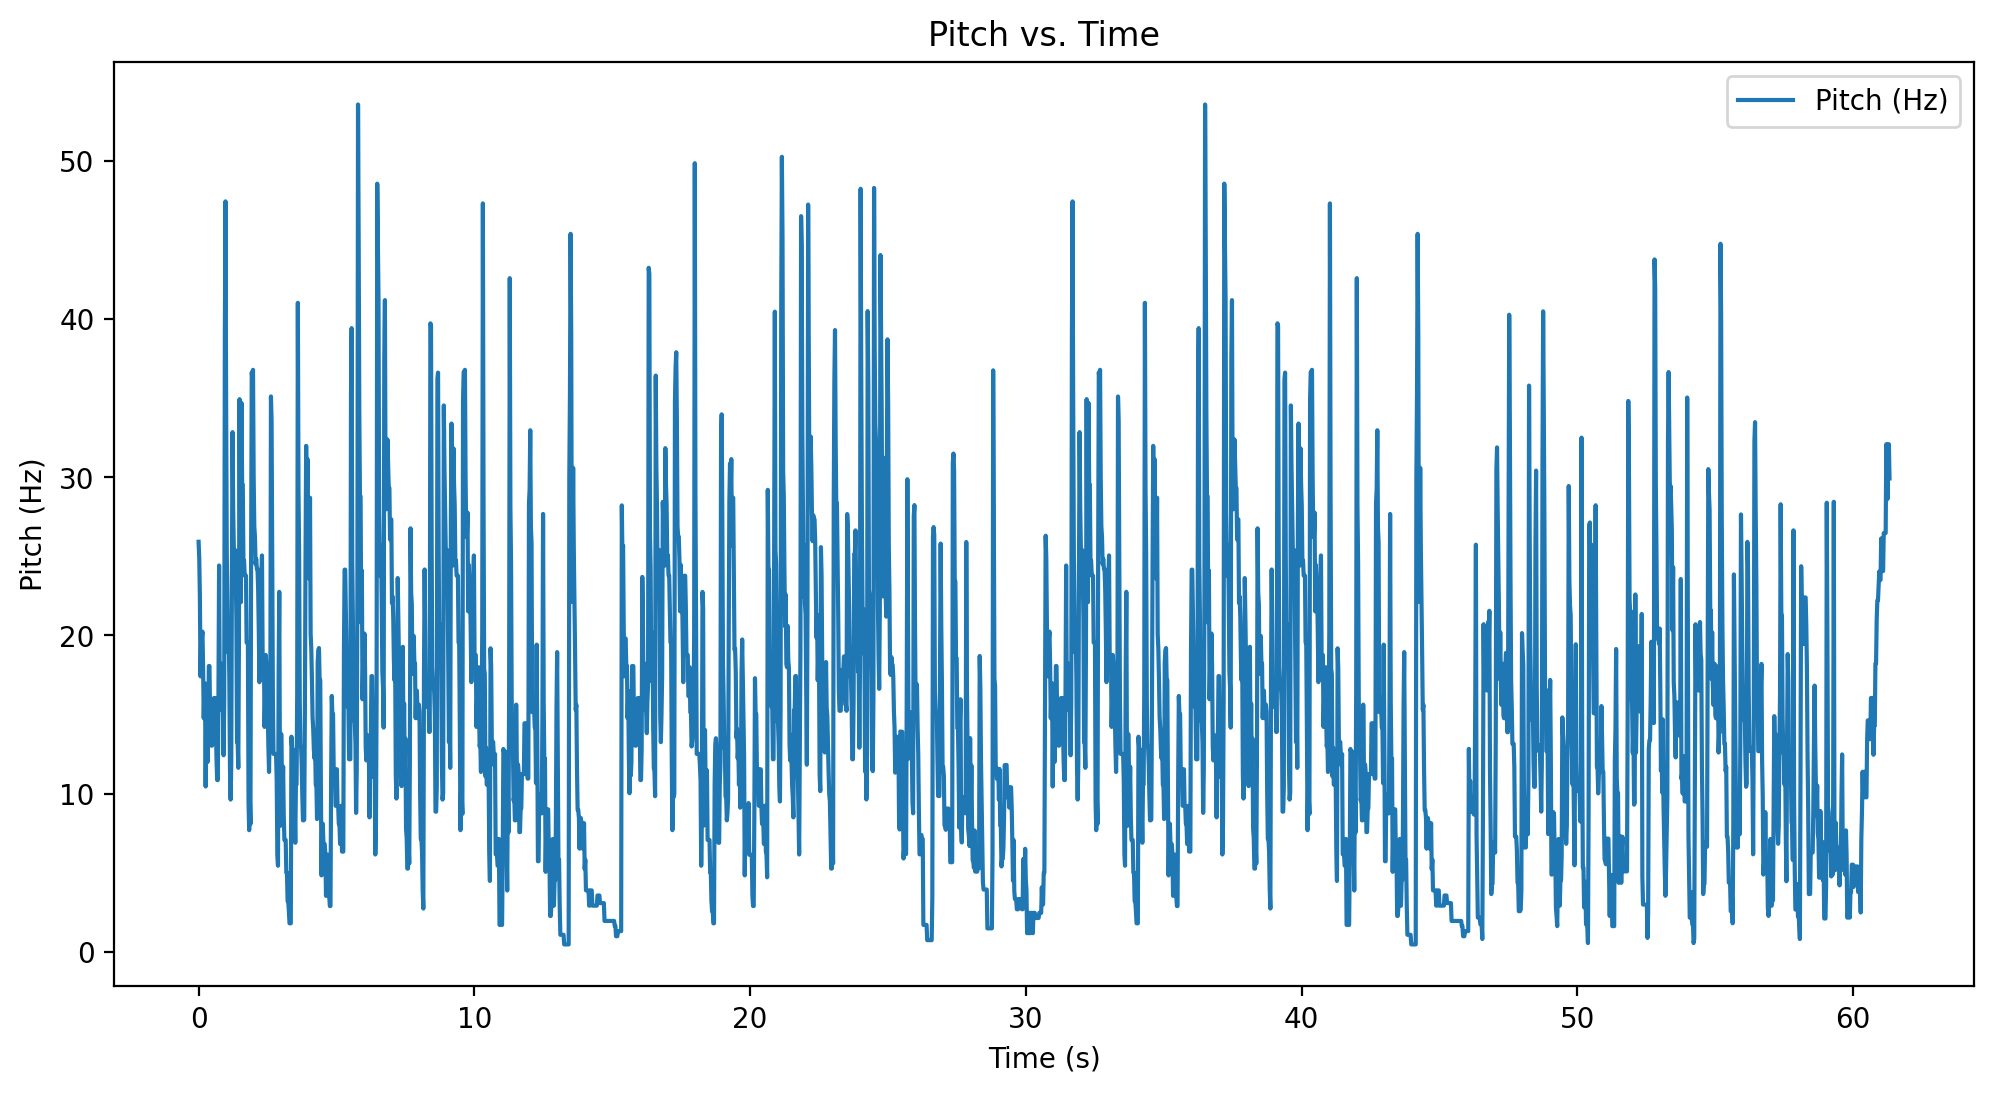

In [ ]:
plot_pitch_time("gdrive/MyDrive/Music Gen/FFIX_Piano.wav")

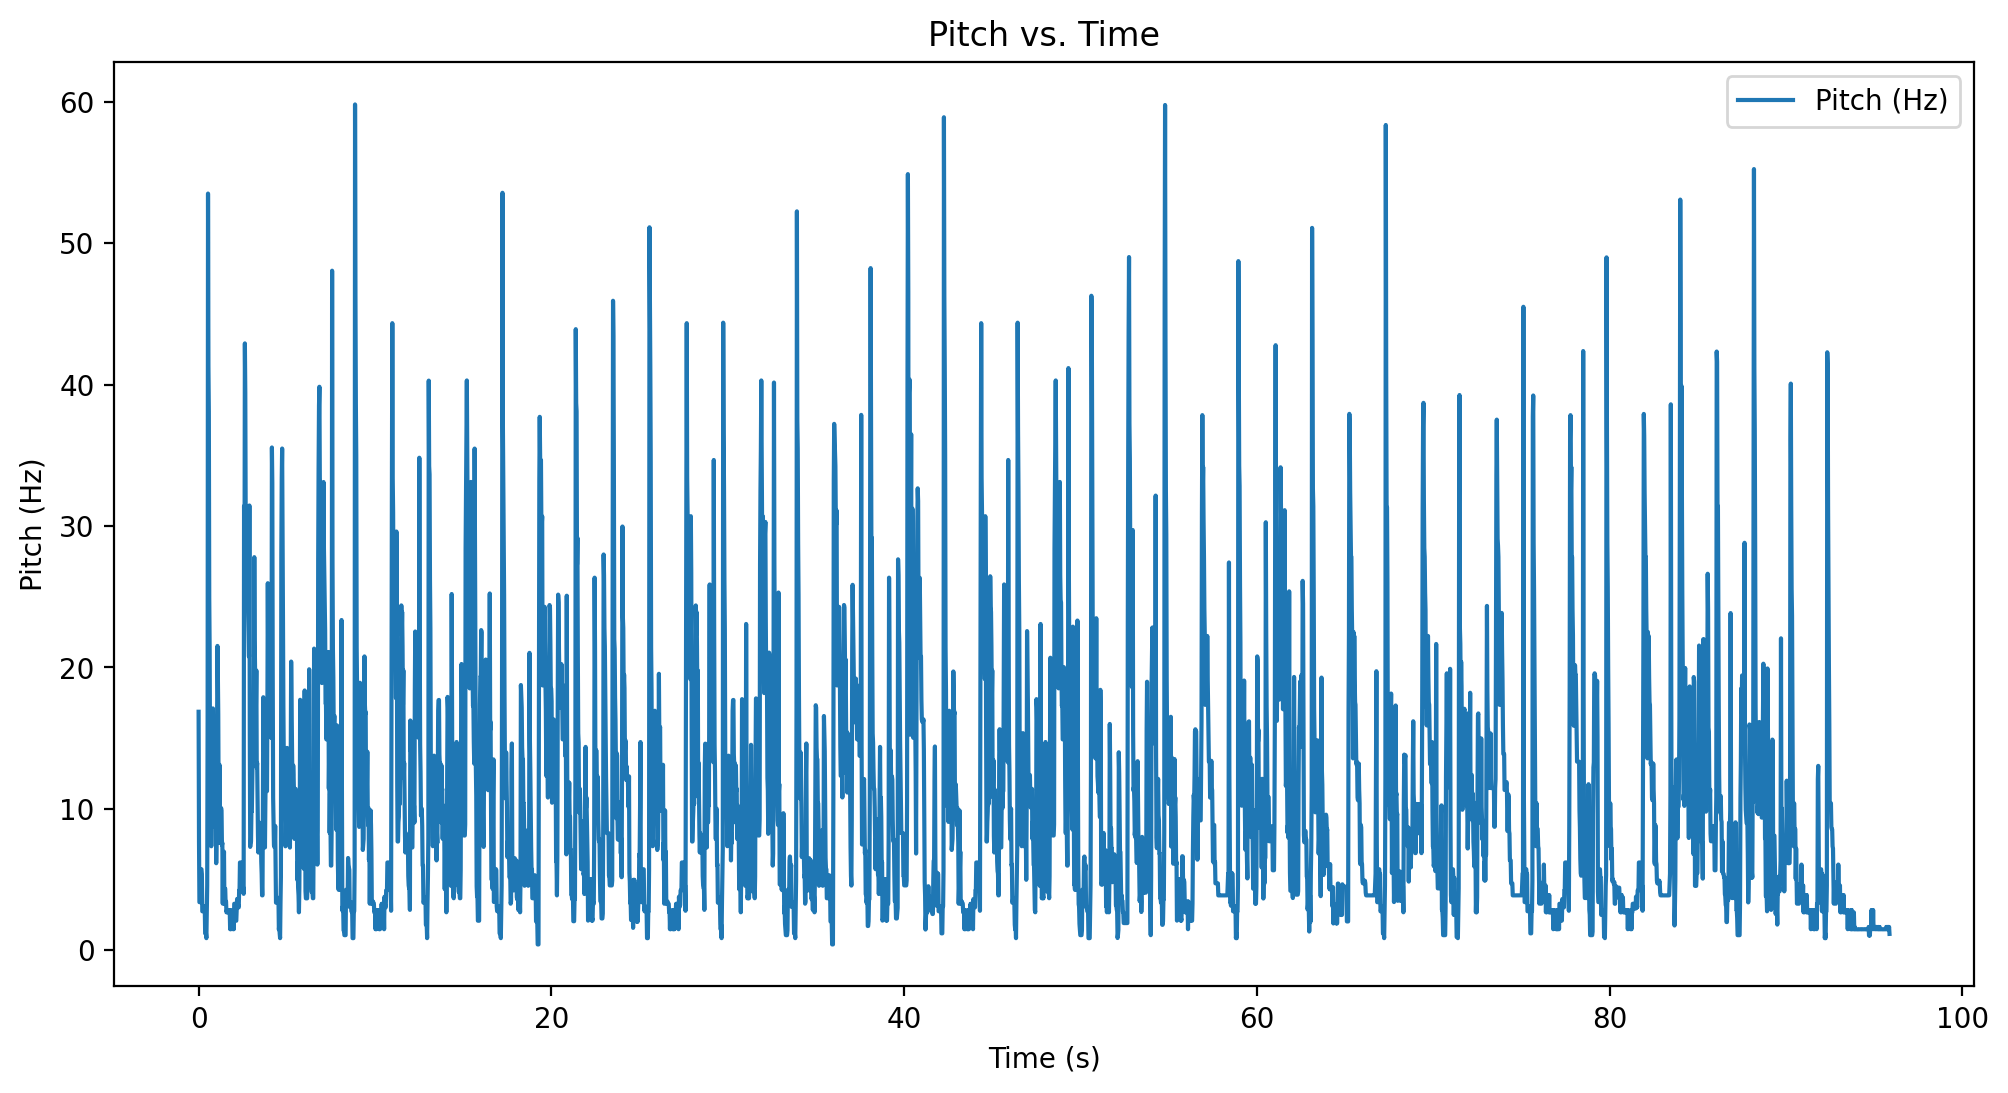

In [ ]:
plot_pitch_time("gdrive/MyDrive/Music Gen/traitor.wav")

In [ ]:
notes = []

for file in glob.glob("gdrive/MyDrive/Music Gen/data/*.mid"):
    midi = converter.parse(file)
    notes_to_parse = None

    parts = instrument.partitionByInstrument(midi)

    if parts:
        notes_to_parse = parts.parts[0].recurse()
    else:
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append(".".join(str(n) for n in element.normalOrder))

In [ ]:
with open ("gdrive/MyDrive/Music Gen/notes", "rb") as fp:
    notes = pickle.load(fp)

In [ ]:
len(notes), notes[0], notes[1]

(57177, '4.9', 'E2')

In [ ]:
sequence_length = 100

pitchnames = sorted(set(item for item in notes))

n_vocab = len(set(notes))

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input_data = []
network_output = []

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]

    network_input_data.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input_data)

network_input = np.reshape(network_input_data, (n_patterns, sequence_length, 1))
network_input = network_input / float(n_vocab)

network_output = keras.utils.to_categorical(network_output)

In [ ]:
n_vocab

352

In [ ]:
model = keras.Sequential([
    keras.layers.LSTM(512, input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(512, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(512),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(n_vocab, activation="softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1052672   
                                                                 
 dropout (Dropout)           (None, 100, 512)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 512)          2099200   
                                                                 
 dropout_1 (Dropout)         (None, 100, 512)          0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
hist = model.fit(network_input, network_output, epochs=200, batch_size=64)

In [ ]:
model.load_weights("gdrive/MyDrive/Music Gen/weights.hdf5")

In [ ]:
start = np.random.randint(0, len(network_input) - 1)

int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

pattern = network_input_data[start]
prediction_output = []

for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)

    prediction = model.predict(prediction_input, verbose=0)

    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)

    pattern.append(index)
    pattern = pattern[1:len(pattern)]

In [ ]:
offset = 0
output_notes = []

for pattern in prediction_output:
    if ("." in pattern) or (pattern.isdigit()):
        notes_in_chord = pattern.split('.')
        new_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            new_notes.append(new_note)
        new_chord = chord.Chord(new_notes)
        new_chord.offset = offset
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    offset += 0.5

In [ ]:
midi_stream = stream.Stream(output_notes)
midi_stream.write("midi", fp="gdrive/MyDrive/Music Gen/test_output.mid")

'gdrive/MyDrive/Music Gen/test_output.mid'